### GIven the plot below, we try to identify contiguous regions of high and low log-ratios

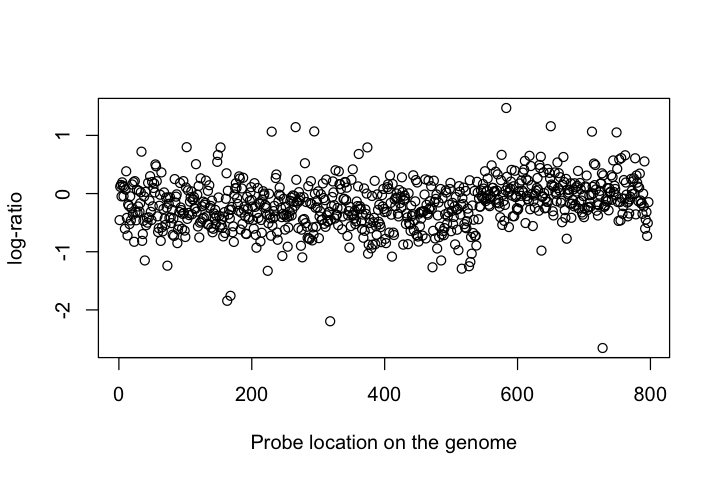

In [2]:
library("changepoint")
data(Lai2005fig3)
options(repr.plot.width=6, repr.plot.height=4)
## Plot 
y <- Lai2005fig3[,5]
par(mfrow=c(1,1))
plot(y, xlab="Probe location on the genome", ylab="log-ratio")

### Consider a two-state homogeneous hidden Markov model with emmision density, state transition probabilities and uniform initial probability given below.

In [3]:
## Input Data
A <- matrix(data=c(0.99,0.01,0.01,0.99),nrow=2,ncol=2)
m <- c(-0.28,0.02)
sigma <- c(0.4,0.4)
mu <- c(0.5,0.5)
T <- length(y)
K <- length(mu)

### We start with defining alpha recursion and beta recursion and run the forward and backward recursions.

In [4]:
## Modify Alpha Recursion
alpha_recursion <- function(y, mu, A, m, sigma){
    alpha = matrix(0, nrow=T,ncol=K)
    
    for (j in 1:K) {
        alpha[1,j] = dnorm(y[1],mean=m[j],sd=sigma[j]) *sum(A[,j]* mu)}
    for (t in 2:T) {
        for (j in 1:K) {
            alpha[t,j] = dnorm(y[t],mean=m[j],sd=sigma[j]) *sum(A[,j]* alpha[t-1,])
        }
    }
return(alpha)
}

## Modify Beta Recursion
beta_recursion <- function(y, mu, A, m, sigma){
    beta = matrix(0, nrow=T,ncol=K)
    for(j in 1:K) {
        beta[T,j] = 1 }
    for (t in T:2) {
        for (i in 1:K) {
            beta[t-1,i] = sum(dnorm(y[t],mean=m[],sd=sigma[])*A[i,]* beta[t,])
        }
    }
    return(beta)
}

In [5]:
## Filtering
alpha <- alpha_recursion(y, mu, A, m, sigma)
filtering <- matrix(data=NA, nrow=T,ncol=K)
for (t in 1:T) {
    filtering[t,] <- alpha[t,]/sum(alpha[t,])
}

## Smoothing
beta <- beta_recursion(y, mu, A, m, sigma)
smoothing <- matrix(data=NA, nrow=T,ncol=K)
for (t in 1:T) {
    smoothing[t,] <- alpha[t,]*beta[t,]/sum(alpha[t,]*beta[t,])
}

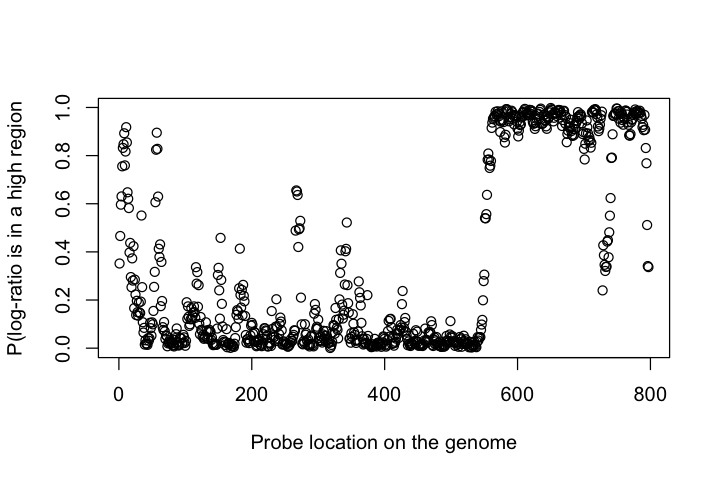

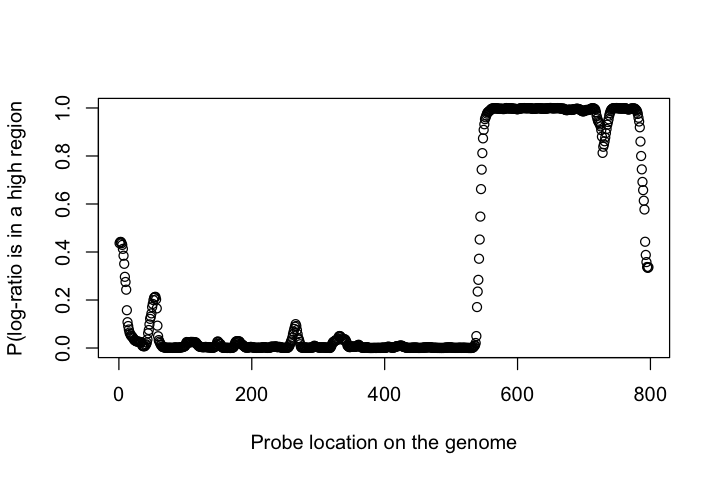

In [6]:
par(mfrow=c(1,1))
## Log Ratio up to time t
plot(filtering[,2],xlab="Probe location on the genome", ylab="P(log-ratio is in a high region") 
## Log Ratio up to time n
plot(smoothing[,2],xlab="Probe location on the genome", ylab="P(log-ratio is in a high region")

### Finally we define Viterbi algorithm and run the algorithm to obtain a maximum posterior (MAP) estimate, which helps us to partition the data into high/low log-ratio segments.

In [7]:
## Modify Viterbi algorithm
viterbi <- function(y, mu, A, m, sigma){ M = matrix(0, nrow=T,ncol=K)
M0 = matrix(0, nrow=1,ncol=K)
x.map = rep(0, T)

# Backward
for (i in 1:K){
    M[T,i] <- 1
}
for (t in T:2){
    for (i in 1:K){
        M[t-1,i] <- max(dnorm(y[t],mean=m[],sd=sigma[])*A[i,]* M[t,])
    }
}
for (i in 1:K) {
    M0[i] <- max(dnorm(y[1],mean=m[],sd=sigma[])*A[i,]* M[1,]) }

                                        
#Forward
x0.map = which.max(M0 * mu)
x.map[1] <- which.max(M[1,]*dnorm(y[1],mean=m[],sd=sigma[])*A[x0.map,])
for (t in 2:T) {
    x.map[t] <- which.max(M[t,]*dnorm(y[t],mean=m[],sd=sigma[])*A[x.map[t-1],])
}
return(x.map)
                                       }

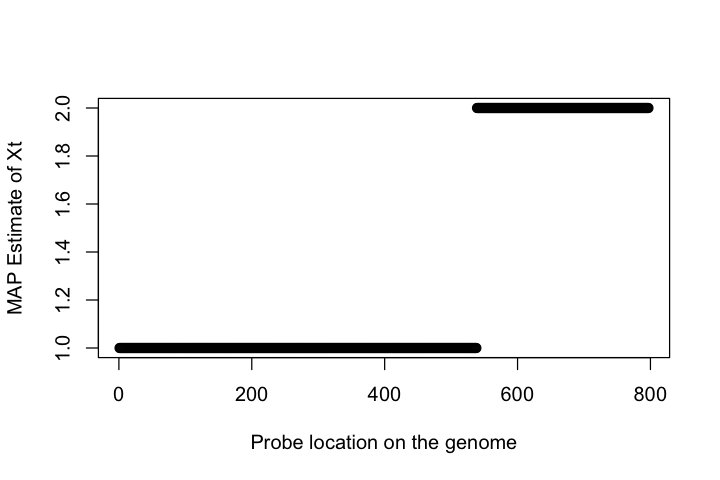

In [8]:
## Most Likely Partition
x.map=viterbi(y, mu, A, m, sigma)
par(mfrow=c(1,1))
plot(x.map,xlab="Probe location on the genome", ylab="MAP Estimate of Xt")

### The graph below shows the empirical cumulative distribution function for low log-ratio and high log-ratio respectively.

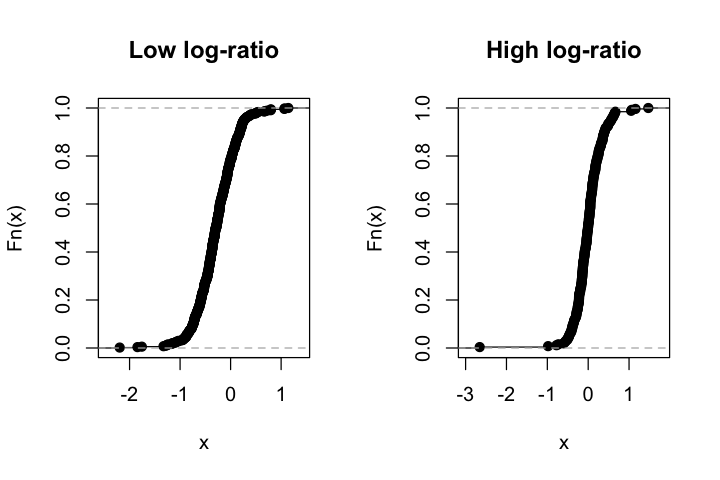

In [9]:
## Empirical distribution
ecdf.x1 = ecdf(y[x.map==1])
ecdf.x2 = ecdf(y[x.map==2])
par(mfrow=c(1,2))
plot(ecdf.x1, xlab = 'x', ylab = 'Fn(x)', main = 'Low log-ratio')
plot(ecdf.x2, xlab = 'x', ylab = 'Fn(x)', main = 'High log-ratio')

### Food for thought, does the high log-ratio segment has a "steeper" shape, suggesting that the data is more "concentrated" towards the mean and thus it's reasonable to use different sigma across 2 segments?